# Failure modes (strategy 5)

In [1]:
import adaptive
adaptive.notebook_extension()

# Import modules that are used in multiple cells
import holoviews as hv
import numpy as np
from functools import partial
import random
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import simps

from adaptive.tests import test_average_learner1d as tests

from adaptive.learner.learner1D import (curvature_loss_function,
                                        uniform_loss,
                                        default_loss,
                                        triangle_loss)

%config InlineBackend.figure_formats=set(['svg'])

In [2]:
def generate_results(strategy,loss_per_interval,delta,min_samples,min_Delta_g,alfa,fun,sigma,bounds,Nvec):
    learner = adaptive.AverageLearner1D(fun,
                                        strategy = strategy,
                                        bounds=bounds, delta=delta, 
                                        min_samples=min_samples, min_Delta_g=min_Delta_g,
                                        alfa=alfa)
    from tqdm.notebook import trange, tqdm
    generate_plots = False
    save_plot = False
    fig_name = None
    errors = None
    extrema = None
    try:
        for max_samples in tqdm(Nvec, desc='Number of samples', leave=True):
            if max_samples == Nvec[-1]:
                generate_plots = True
                print('strategy = %d'%strategy)
                print('\u03B4 = %.2f'%delta)
                print('\u03C3 = %.2f'%sigma)
            max_samples = int(max_samples)
            errors, extrema = tests.test_single_error(learner, max_samples, errors=errors, 
                                                      extrema=extrema,
                                                      generate_plot=generate_plots, 
                                                      calculate_uniform=False,
                                                      save_plot=save_plot, 
                                                      fig_name=fig_name, 
                                                      fittings=False,
                                                      progress_bars=None)
    except KeyboardInterrupt:
        print('Interrupted!')
        print('strategy = %d'%strategy)
        print('\u03B4 = %.2f'%delta)
        print('\u03C3 = %.2f'%sigma)
        errors, extrema = tests.test_single_error(learner, 0, errors=errors, 
                                                  extrema=extrema,
                                                  generate_plot=True, 
                                                  calculate_uniform=False,
                                                  save_plot=save_plot, 
                                                  fig_name=fig_name, 
                                                  fittings=False,
                                                  progress_bars=None)
    
    return learner

<br>
&nbsp;

## New-samples failure mode (NSFM)

In strategy 5, larger values of $\delta$ favor the "exploration" instead of the "exploitation".

If $\delta$ is too large, the size of the intervals decreases too much faster than the uncertainties. Hence, the choice of interval for new sample is very noisy (it is based on bad estimates of true function values), leading the learner to add new points in regions that seem interesting but are not. This way, the learner gets stuck in the "exploration" behavior, adding new points, and does not resample the existing ones.

Although __this effect disappears with growing $N$__, it can harm the efficiency of the learner, since the first hundreds or thousands of samples could be invested in sampling noise.

Luckily, __the NSFM can be solved by raising the value of min_samples__, unless $\delta$ is excessively large ($\delta>1$, in general).

<br>
&nbsp;
-Example of NSFM happening because of a poor choice of $\delta$ (too large):

δ = 1.00
σ = 1.00
min_samples = 1


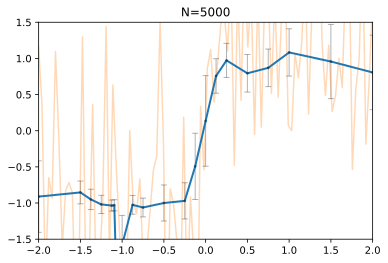

In [44]:
# Learner params
strategy = 5
min_samples = 1
alfa = 0.005
delta = 1
loss_per_interval = default_loss
loss_per_interval = triangle_loss

# Function params
sigma = 1
bounds = [-2,2]
fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)

# Other params
N = 5000

randomseed = 2

## -----------------------------------

random.seed(randomseed)
np.random.seed(randomseed)

print('\u03B4 = %.2f'%delta)
print('\u03C3 = %.2f'%sigma)
print('min_samples = %d'%min_samples)
learner = adaptive.AverageLearner1D(fun, loss_per_interval=loss_per_interval,
                                    strategy = strategy,
                                    bounds=bounds, delta=delta, 
                                    min_samples=min_samples, alfa=alfa)
tests.run_N(learner,N)
tests.plot_learner(learner,ylim=[-1.5,1.5])

<br>
&nbsp;
<br>
&nbsp;
<br>
&nbsp;
-Solving the previous NSFM with min_samples=150:

δ = 1.00
σ = 1.00
min_samples = 150


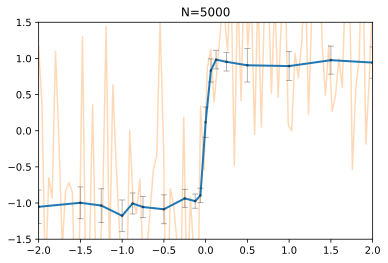

In [45]:
# Learner params
strategy = 5
min_samples = 150
alfa = 0.005
delta = 1
loss_per_interval = default_loss
loss_per_interval = triangle_loss

# Function params
sigma = 1
bounds = [-2,2]
fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)

# Other params
N = 5000

randomseed = 2

## -----------------------------------

random.seed(randomseed)
np.random.seed(randomseed)

print('\u03B4 = %.2f'%delta)
print('\u03C3 = %.2f'%sigma)
print('min_samples = %d'%min_samples)
learner = adaptive.AverageLearner1D(fun, loss_per_interval=loss_per_interval,
                                    strategy = strategy,
                                    bounds=bounds, delta=delta, 
                                    min_samples=min_samples, alfa=alfa)
tests.run_N(learner,N)
tests.plot_learner(learner,ylim=[-1.5,1.5])

<br>
&nbsp;
<br>
&nbsp;
<br>
&nbsp;
-NSFM returns if we excessively increase $\delta$ (still with min_samples=150):

δ = 5.00
σ = 1.00
min_samples = 150


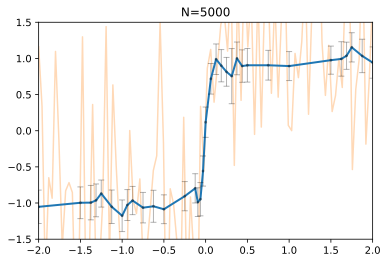

In [46]:
# Learner params
strategy = 5
min_samples = 150
alfa = 0.005
delta = 5
loss_per_interval = default_loss
loss_per_interval = triangle_loss

# Function params
sigma = 1
bounds = [-2,2]
fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)

# Other params
N = 5000

randomseed = 2

## -----------------------------------

random.seed(randomseed)
np.random.seed(randomseed)

print('\u03B4 = %.2f'%delta)
print('\u03C3 = %.2f'%sigma)
print('min_samples = %d'%min_samples)
learner = adaptive.AverageLearner1D(fun, loss_per_interval=loss_per_interval,
                                    strategy = strategy,
                                    bounds=bounds, delta=delta, 
                                    min_samples=min_samples, alfa=alfa)
tests.run_N(learner,N)
tests.plot_learner(learner,ylim=[-1.5,1.5])

<br>
&nbsp;

## Resampling failure mode

The resampling failure mode (RFM) happens when the learner decides to resample existing points instead of sampling new ones for a long period. This is not necessarily bad, since every time a new point is added we expect the learner to resample it many times. However, if the RFM appears too soon (for small number of samples $N$), the error will decrease slowly, since new points would probably be more useful and provide more information about the function.

Small values of $\delta$ favor the "exploitation" behavior, i.e. resampling existing points.

If $\delta$ is too small, the learner will soon try to excessively reduce the uncertainty of the existing points, getting stuck in this behavior and not sampling new points.
Consequently, the RFM appears early and becomes a problem for the learner.
This can be seen in the following experiment (an RFM happens in those regions in which $n(N)$ is constant):

strategy = 5
δ = 0.01
σ = 1.00


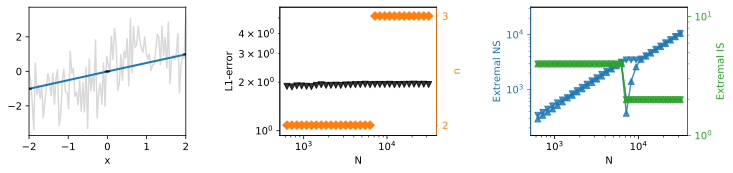

In [42]:
# Learner params
strategy = 5
min_samples = 200
alfa = 0.005
delta = 0.01
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-2,2]

# Other params
Nvec = np.logspace(2.8,4.5,30)

#Nvec = np.linspace(10**1,10**2,50)

randomseed = 2

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)
generate_results(strategy,loss_per_interval,delta,min_samples,
                 min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

A proper value of $\delta$ leads to short RFMs that do not harm the efficiency of the learner:

strategy = 5
δ = 0.70
σ = 1.00


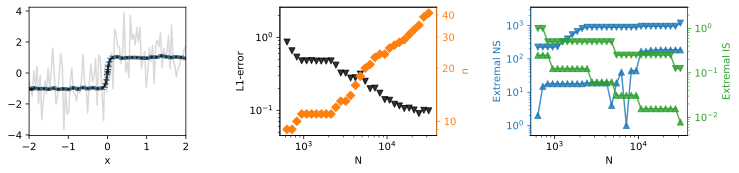

In [56]:
# Learner params
strategy = 5
min_samples = 1
alfa = 0.005
delta = 0.7
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-2,2]

# Other params
Nvec = np.logspace(2.8,4.5,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)
generate_results(strategy,loss_per_interval,delta,min_samples,
                 min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

If $\delta$ is too large, the RFM will also appear early. This happens because a lot of points will be fastly added into the data, reducing the interval sizes. Hence, there will be a large number of points that require resampling. The RFM produced by a large $\delta$ are harmful for the efficiency of the learner since they imply that the learner has sampled noise.
This is observed in the following experiment:

strategy = 5
δ = 1.50
σ = 1.00


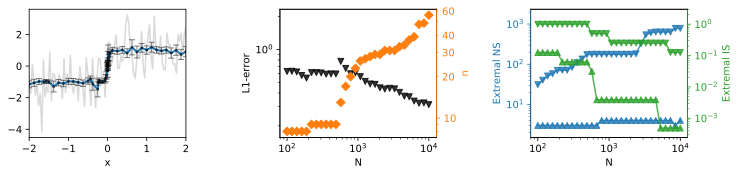

In [82]:
# Learner params
strategy = 5
min_samples = 1
alfa = 0.005
delta = 1.5
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-2,2]

# Other params
Nvec = np.logspace(2.8,4.5,30)

randomseed = 2

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)
generate_results(strategy,loss_per_interval,delta,min_samples,
                 min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;
<br>
&nbsp;

As we have seen, an intermediate value of $\delta$ balance "exploration" and "exploitation", delaying the RFM.
However, this is unavoidable: the RFM will appear at some point. After that, the learner will continuously get out of an RFM and jump into another RFM with longer steps (we can see this in the steps of the previous plots --they actually seem to be shorter for larger $N$, but this is only a graphical effect, consequence of the log scale). As previously mentioned, this is not a bad behavior per se. After a lot of points have been sampled, it may be more efficient to invest more samples on them rather than on new points.

Nevertheless, we can prevent the steps of the RFM from getting longer by setting a minimum uncertainty $\Delta g^\text{min}$ (variable min_Delta_g in the code). By doing this, the learner will not resample those points $x_i$ whose uncertainty $\Delta g_i$ is smaller than $\Delta g^\text{min}$.

In the following example, we use the same settings as in the experiment with $\delta=0.01$ (which lead to only 3 points being sampled) but with $\Delta g_i=0.07$:

min_Delta_g = 0.07


strategy = 5
δ = 0.01
σ = 1.00


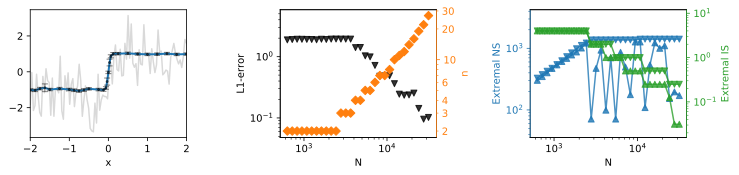

In [55]:
# Learner params
strategy = 5
min_samples = 200
alfa = 0.005
delta = 0.01
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0.07


# Function params
sigma = 1
bounds = [-2,2]

# Other params
Nvec = np.logspace(2.8,4.5,30)

#Nvec = np.linspace(10**1,10**2,50)

randomseed = 3

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

print('min_Delta_g = %.2f'%min_Delta_g)
fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)
learner = generate_results(strategy,loss_per_interval,delta,min_samples,
                           min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

Let us summarize our findings.

The learner constantly balances "exploration" (adding new points) with "exploitation" (resampling existing points). As the number of samples grows, the exploitation becomes more demanding, and produces RFM. Each time the learner needs to exploit existing points, it will require a lot of new samples, getting stuck in this behavior (RFM). After a while, it will explore new points and then fall into another long stage of RFM to exploit existing points.

The new parameter we have introduced, $\Delta g^\text{min}$, limits the duration of the RFMs in $N$. This is a useful tool in those cases in which we know that exploitation beyond a certain limit is not useful for our purposes (e.g. we can set $\Delta g^\text{min}=10$ $\mu V$ in an experiment in which the order of magnitude of the voltages measured is $1$ $V$), and in those situations in which we are not sure if we chose a too small $\delta$.

<br>
&nbsp;

# Optimal $\delta$ to avoid RFM: what does it depend on?

__*THIS SECTION IS UNDER CONSTRUCTION, YOU CAN STOP READING HERE*__

Here, we try to find the parameters that affect the optimal value of $\delta$. 

The learner parameters min_samples and $\Delta g^\text{min}$ can be used to prevent the failure modes. However, here we assume that none of them is used to improve the results. Instead, we try to find the optimal $\delta$ for min_samples$=50$ and $\Delta g^\text{min}=0$. The results provided by the optimal $\delta$ can then be improved by choosing different values for these two parameters.

### -Noise?

In the following experiment, we first use $\sigma=0.1$ and the optimal $\delta$ is around:
 - $0.01$: X, early RFM
 - $0.05$: √, but a bit RFM and larger error than $0.1$
 - $0.1$:  √
 - $0.5$:  √, but NSFM and larger error than $0.1$ in the long term
 - $1$:    X, NSFM and larger error than $0.1$ in the long term

strategy = 5
δ = 0.10
σ = 0.10


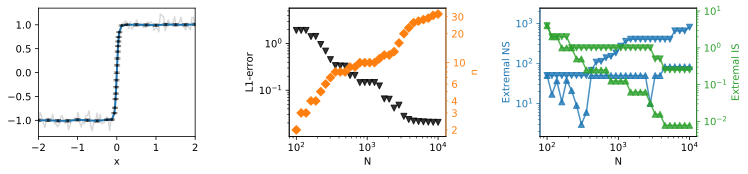

In [66]:
# Learner params
strategy = 5
min_samples = 50
alfa = 0.005
delta = 0.1
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.1
bounds = [-2,2]

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)
generate_results(strategy,loss_per_interval,delta,min_samples,
                 min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

In the same experiment, we now use $\sigma=1$ and the optimal $\delta$ is around:
 - $0.01$: X, early and very strong RFM
 - $0.05$: X, early and strong RFM
 - $0.1$: X, early RFM
 - $0.5$: √
 - $1$: X, NSFM

strategy = 5
δ = 0.50
σ = 1.00


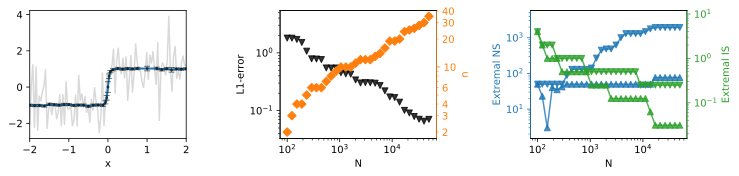

In [74]:
# Learner params
strategy = 5
min_samples = 50
alfa = 0.005
delta = 0.5
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-2,2]

# Other params
Nvec = np.logspace(2,4.7,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

fun = partial(tests.tanh, sigma = sigma, stretching = 20, height = 1)
generate_results(strategy,loss_per_interval,delta,min_samples,
                 min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

Conclusion: the optimal $\delta$ depends on the std of noise. Larger $\sigma$ requires larger $\delta$.

<br>
&nbsp;

### -Function?

In the following experiment, we check if $\delta\approx0.1$ is also optimal for other functions besides the previous tanh, as long as $\sigma=0.1$.

__Peak__:
 - $0.01$: X, early RFM
 - $0.05$: X, early RFM
 - $0.1$:  √, but a bit of RFM
 - $0.5$:  X, NSFM
 - $1$:    X, extreme NSFM
 
Looks like the peak is more sensitive to $\delta$ than the tanh.

strategy = 5
δ = 0.10
σ = 0.10


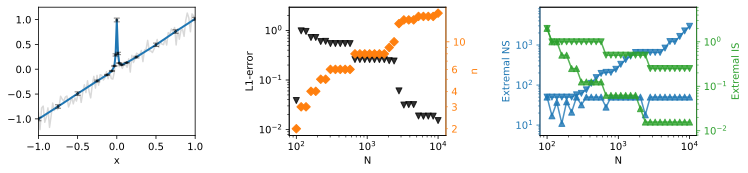

In [89]:
# Learner params
strategy = 5
min_samples = 50
alfa = 0.005
delta = 0.1
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.1
bounds = [-1,1]

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

fun = partial(tests.peak, sigma = sigma)
generate_results(strategy,loss_per_interval,delta,min_samples,
                 min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

__Lorentzian__:

Similar to the peak.

strategy = 5
δ = 0.10
σ = 0.10


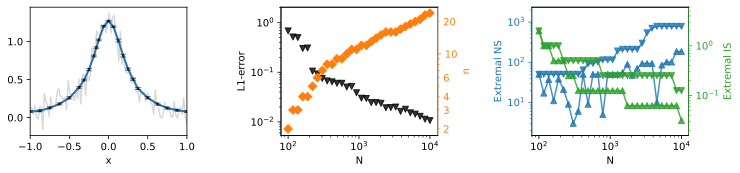

In [95]:
# Learner params
strategy = 5
min_samples = 50
alfa = 0.005
delta = 0.1
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.1
bounds = [-1,1]

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

fun = partial(tests.lorentz_add, sigma = sigma)
generate_results(strategy,loss_per_interval,delta,min_samples,
                 min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

Chirped sinusoid:
 - $0.01$: X, extreme RFM
 - $0.05$: X, extreme RFM
 - $0.1$:  X, RFM
 - $0.5$: √, shows NSFM but it is good in this case
 - $1$:   √, shows NSFM but it is good in this case


strategy = 5
δ = 0.50
σ = 0.10


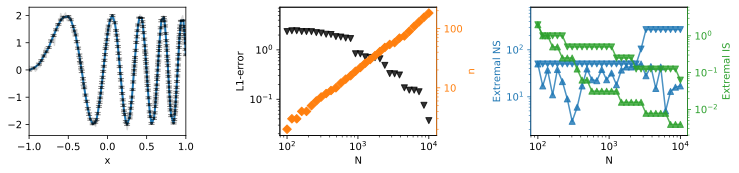

In [15]:
# Learner params
strategy = 5
min_samples = 50
alfa = 0.005
delta = 0.5
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.1
bounds = [-1,1]
fun = partial(tests.sinusoid, A = 2, freq = 7, offset=-1, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

strategy = 5
δ = 0.05
σ = 0.10


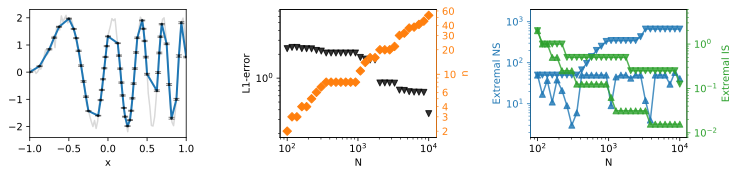

In [17]:
# Learner params
strategy = 5
min_samples = 50
alfa = 0.005
delta = 0.05
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.1
bounds = [-1,1]
fun = partial(tests.sinusoid, A = 2, freq = 7, offset=-1, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

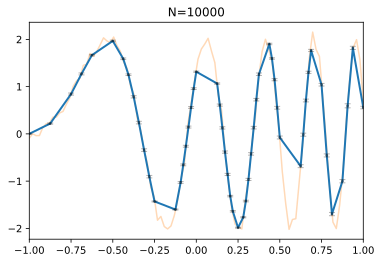

In [18]:
tests.plot_learner(l)

Interrupted!
strategy = 5
δ = 0.50
σ = 1.00


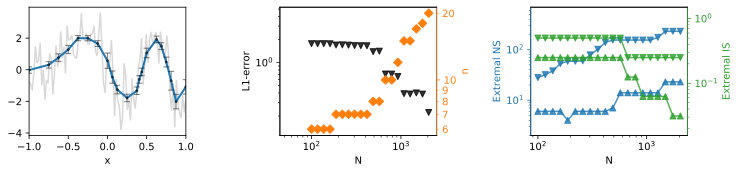

In [26]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 0.5
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-1,1]
fun = partial(tests.sinusoid, A = 2, freq = 3, offset=-1, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

__Conclusion__:

The optimal $\delta$ also depends on the function, not only on the noise.

2: X, NSFM
1.5: √
1: X, RFM
0.5: X, RFM

strategy = 5
δ = 2.50
σ = 1.00


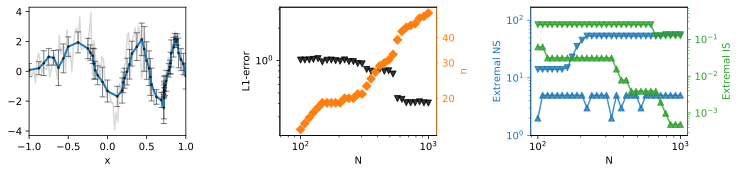

In [47]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 2.5
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-1,1]
fun = partial(tests.sinusoid, A = 2, freq = 4, offset=-1, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,3,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

### -Function y-scale?

<br>
&nbsp;

Chirped sinusoid with large ratio amplitude/period:
 - $0.05$: X, RFM
 - $0.2$:  √, but could be better (top of the waves a bit spiky)
 - $0.5$: √
 - $1$:   √
 - $1.5$: X, NSFM



strategy = 5
δ = 1.50
σ = 1.00


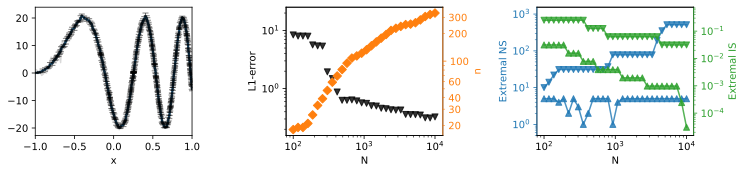

In [67]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 1.5
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-1,1]
fun = partial(tests.sinusoid, A = 20, freq = 4, offset=-1, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

Chirped sinusoid with small ratio amplitude/period:
 - $0.01$: X, RFM
 - $0.05$: √, although tops are a bit spiky
 - $0.1$: X, a bit of NSFM
 - $1$:   X, NSFM


strategy = 5
δ = 0.08
σ = 0.05


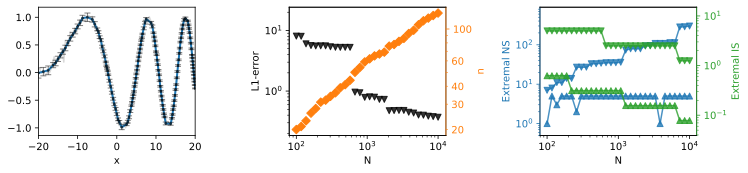

In [77]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 0.08
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.05
bounds = [-20,20]
fun = partial(tests.sinusoid, A = 1, freq = 0.01, offset=-20, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

Chirped sinusoid with small ratio amplitude/period and larger $\sigma$ than before:
 - $0.01$: X, RFM
 - $0.08$: X, spiky
 - $0.1$: √, but spiky
 - $0.3$: X, NSFM
 - $0.5$  X, NSFM
 - $1$:   X, NSFM


strategy = 5
δ = 0.20
σ = 1.00


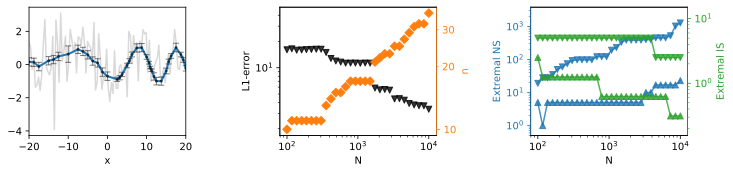

In [89]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 0.2
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 1
bounds = [-20,20]
fun = partial(tests.sinusoid, A = 1, freq = 0.01, offset=-20, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,4,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

Chirped sinusoid with small ratio amplitude/period and early stopping:
 - $0.05$: X, RFM
 - $0.1$:  √, a bit spiky
 - $0.5$:  X, NSFM


strategy = 5
δ = 0.05
σ = 0.05


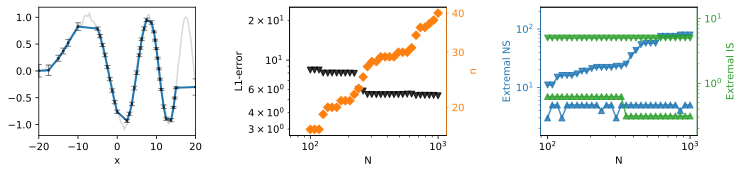

In [92]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 0.05
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.05
bounds = [-20,20]
fun = partial(tests.sinusoid, A = 1, freq = 0.01, offset=-20, chirp=True, sigma = sigma)

# Other params
Nvec = np.logspace(2,3,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

### -N?

<br>
&nbsp;

Tanh up to $N=10^3$:
 - $0.005$: X, RFM
 - $0.01$:  X, RFM
 - $0.05$: √
 - $0.1$: X, NSFM

strategy = 5
δ = 0.10
σ = 0.01


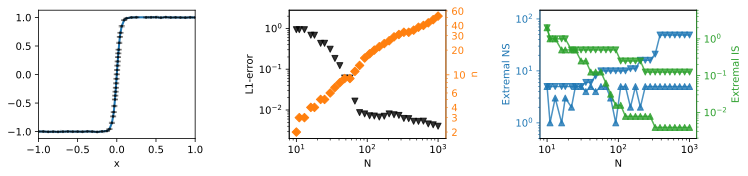

In [103]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 0.1
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.01
bounds = [-1,1]
fun = partial(tests.tanh, stretching=20, sigma = sigma)

# Other params
Nvec = np.logspace(1,3,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

<br>
&nbsp;

Tanh up to $N=10^2$:
 - $0.005$: X, RFM
 - $0.01$:  X, RFM
 - $0.05$: RFM
 - $0.1$: √

strategy = 5
δ = 0.05
σ = 0.01


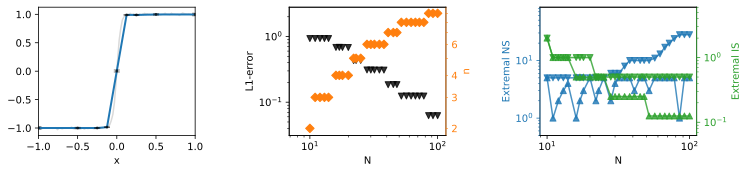

In [105]:
# Learner params
strategy = 5
min_samples = 5
alfa = 0.005
delta = 0.05
loss_per_interval = default_loss
loss_per_interval = triangle_loss
min_Delta_g = 0

# Function params
sigma = 0.01
bounds = [-1,1]
fun = partial(tests.tanh, stretching=20, sigma = sigma)

# Other params
Nvec = np.logspace(1,2,30)

randomseed = 1

random.seed(randomseed)
np.random.seed(randomseed)

## -----------------------------------

l = generate_results(strategy,loss_per_interval,delta,min_samples,
                     min_Delta_g,alfa,fun,sigma,bounds,Nvec)

### -Bounds?

### -Loss?